In [3]:
!pip3 install git+https://github.com/aleju/imgaug

  Cloning https://github.com/aleju/imgaug to c:\users\xrexn\appdata\local\temp\pip-req-build-u3ytg2yh
  Resolved https://github.com/aleju/imgaug to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326


  Running command git clone -q https://github.com/aleju/imgaug 'C:\Users\xrexn\AppData\Local\Temp\pip-req-build-u3ytg2yh'


In [5]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa

In [7]:
def plot_pair(images, gray=False):

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,8))
    i=0
    
    for y in range(2):
        if gray:
            axes[y].imshow(images[i], cmap='gray')
        else:
            axes[y].imshow(images[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i+=1
    
    plt.show()

In [8]:
def get_poly(ann_path):
    
    with open(ann_path) as handle:
        data = json.load(handle)
    
    shape_dicts = data['shapes']
    
    return shape_dicts

In [9]:
def create_binary_masks(im, shape_dicts):
    
    blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)
    
    for shape in shape_dicts:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(blank, [points], 255)
        
    return blank

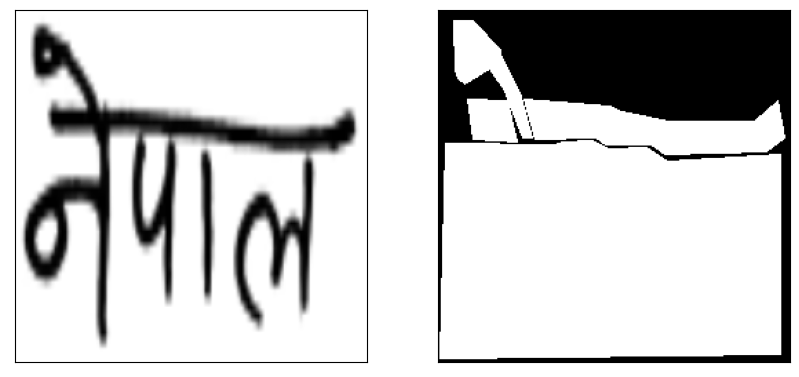

In [10]:
image_list = sorted(os.listdir('images'), key=lambda x: int(x.split('.')[0]))
annot_list = sorted(os.listdir('annotated'), key=lambda x: int(x.split('.')[0]))

for im_fn, ann_fn in zip(image_list, annot_list):
    
    im = cv2.imread(os.path.join('images', im_fn), 0)
    
    ann_path = os.path.join('annotated', ann_fn)
    shape_dicts = get_poly(ann_path)
    im_binary = create_binary_masks(im, shape_dicts)
    
    plot_pair([im, im_binary], gray=True)
    plt.show()
    break

In [11]:
hues = {'dika': 30,
        'character': 0
       }

labels = sorted(hues.keys())
print(labels)

['character', 'dika']


In [12]:
def create_multi_masks(im, shape_dicts):
    
    channels = []
    cls = [x['label'] for x in shape_dicts]
    poly = [np.array(x['points'], dtype=np.int32) for x in shape_dicts]
    label2poly = dict(zip(cls, poly))
    background = np.zeros(shape=im.shape, dtype=np.float32)

    for i, label in enumerate(labels):
        
        blank = np.zeros(shape=im.shape, dtype=np.float32)
        
        if label in cls:
            cv2.fillPoly(blank, [label2poly[label]], 255)
            cv2.fillPoly(background, [label2poly[label]], 255)
            
        channels.append(blank)
    _, thresh = cv2.threshold(background, 127, 255, cv2.THRESH_BINARY_INV)
    channels.append(thresh)

    Y = np.stack(channels, axis=2)
    return Y

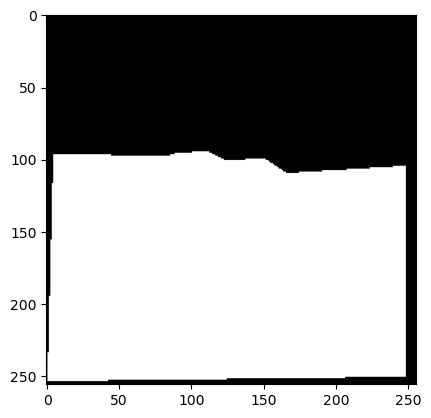

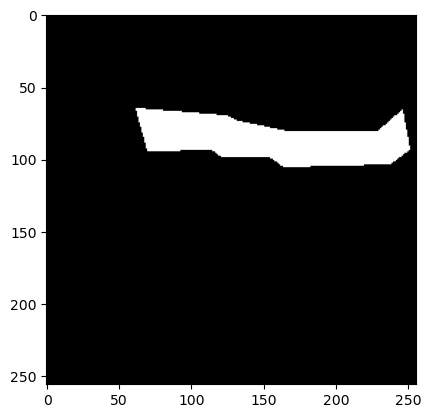

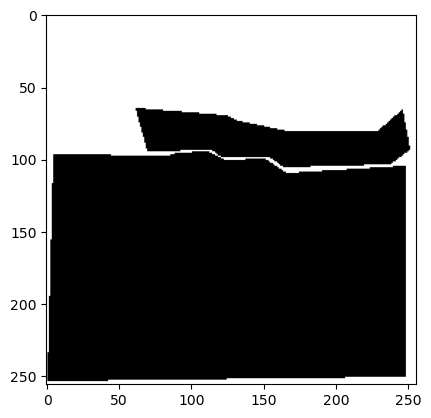

In [13]:
for im_fn, ann_fn in zip(image_list, annot_list):
    
    im = cv2.imread(os.path.join('images', im_fn), 0)
    ann_path = os.path.join('annotated', ann_fn)
    shape_dicts = get_poly(ann_path)
    Y = create_multi_masks(im, shape_dicts)
    break
    
for i in range(3):
    mask = Y[:,:,i]
    plt.imshow(mask, cmap='gray')
    plt.show()

In [14]:

def draw_multi_masks(im, shape_dicts):
    
    blank = np.zeros(shape=im.shape, dtype=np.uint8)
    
    channels = []
    cls = [x['label'] for x in shape_dicts]
    poly = [np.array(x['points'], dtype=np.int32) for x in shape_dicts]
    label2poly = dict(zip(cls, poly))

    for i, label in enumerate(labels):
        
        if label in cls:
            cv2.fillPoly(blank, [label2poly[label]], (hues[label], 255, 255))
            
    return cv2.cvtColor(blank, cv2.COLOR_HSV2RGB)

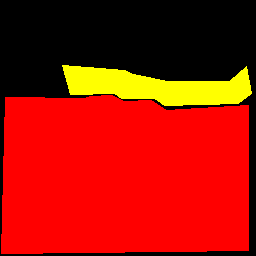

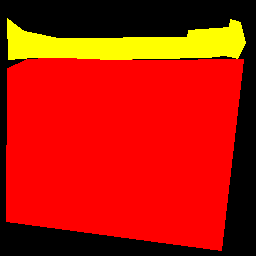

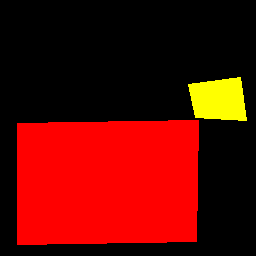

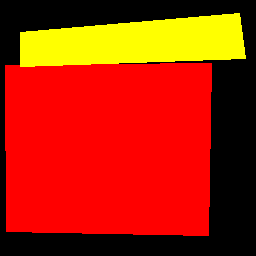

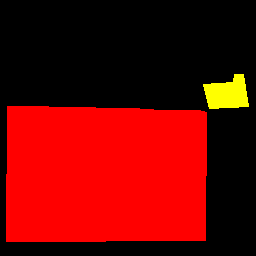

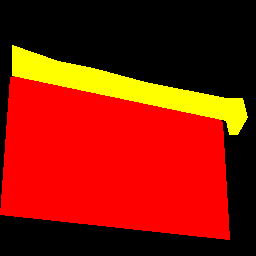

In [16]:
for i, (im_fn, ann_fn) in enumerate(zip(image_list, annot_list)):
    
    im = cv2.imread(os.path.join('images', im_fn), 1)
    ann_path = os.path.join('annotated', ann_fn)
    shape_dicts = get_poly(ann_path)
    im_color = draw_multi_masks(im, shape_dicts)
    display(Image.fromarray(im_color))
    if i == 5:
        break

In [17]:
def augment_poly(im_path, ann_path):
    
    im = cv2.imread(im_path, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    with open(ann_path) as handle:
        data = json.load(handle)
    
    shape_dicts = data['shapes']
    points = []
    aug_shape_dicts = []
    i = 0
    
    for shape in shape_dicts:
        
        for pairs in shape['points']:
            points.append(ia.Keypoint(x=pairs[0], y=pairs[1]))
        
        _d = {}
        _d['label'] = shape['label']
        _d['index'] = (i, i+len(shape['points']))
        aug_shape_dicts.append(_d)

        i += len(shape['points'])
    
    keypoints = ia.KeypointsOnImage(points, shape=(256,256,3))
    
    image_aug = seq_det.augment_images([im])[0]
    keypoints_aug = seq_det.augment_keypoints([keypoints])[0]
    
    for shape in aug_shape_dicts:
        start, end = shape['index']
        aug_points = [[keypoint.x, keypoint.y] for keypoint in keypoints_aug.keypoints[start:end]]
        shape['points'] = aug_points
    
    return image_aug, aug_shape_dicts

In [18]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Multiply((1.2, 1.5)),
    iaa.Affine(
        rotate=(-90, 90)
    ),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 10))
    )
], random_order=True)

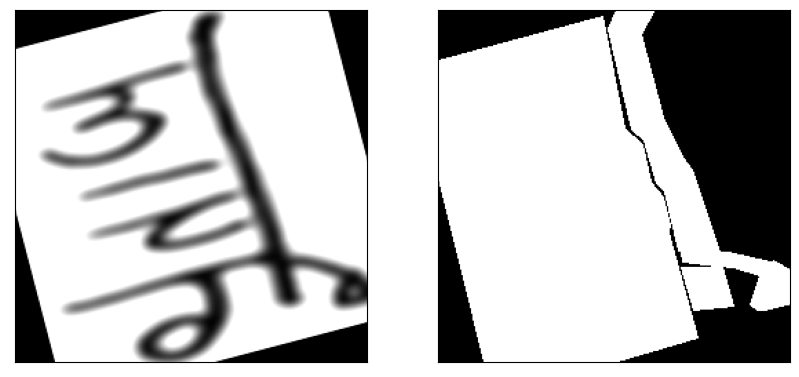

In [20]:
seq_det = seq.to_deterministic()
im_path = os.path.join('images', '0.png')
ann_path = os.path.join('annotated', '0.json')

im_aug, aug_shape_dicts = augment_poly(im_path, ann_path)
aug_mask = create_binary_masks(im_aug, aug_shape_dicts)
plot_pair((im_aug, aug_mask), gray=True)

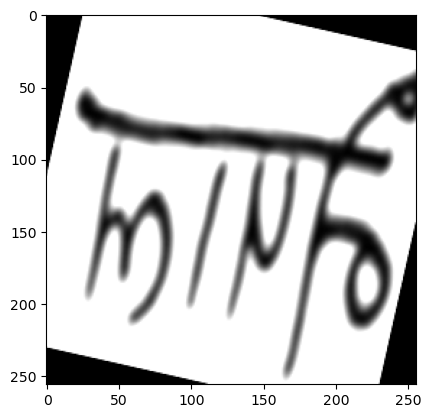

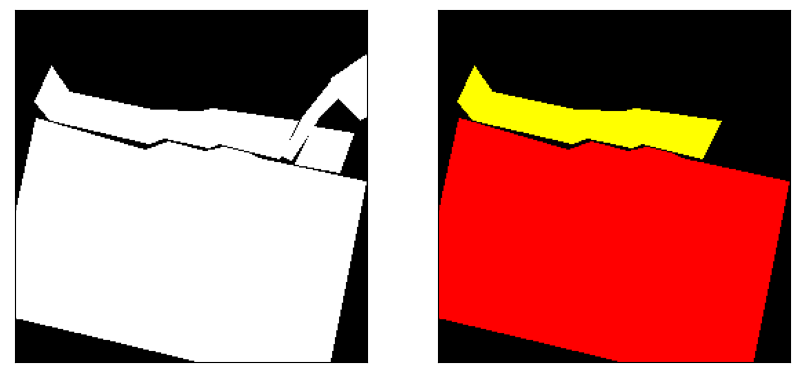

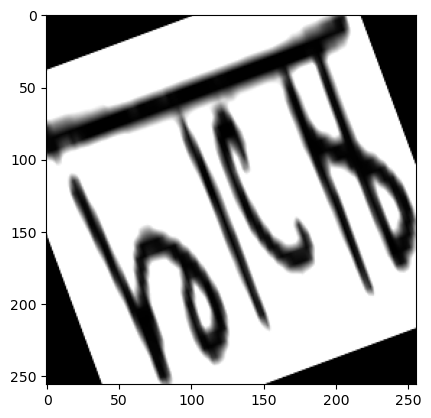

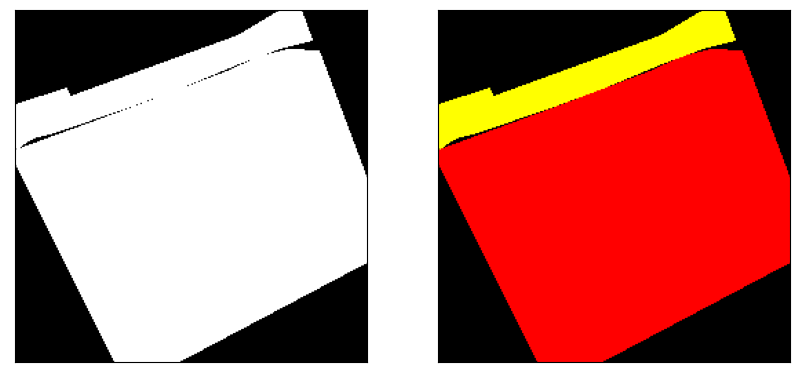

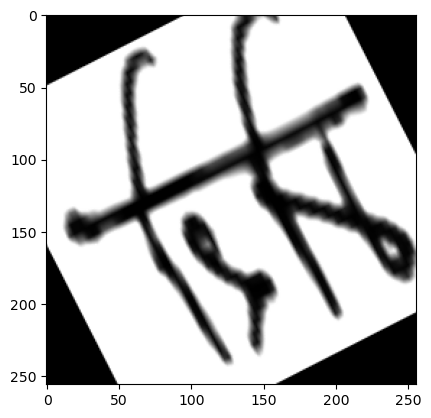

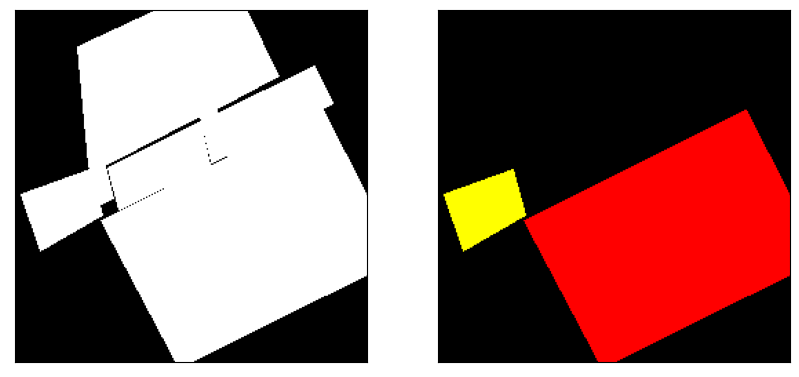

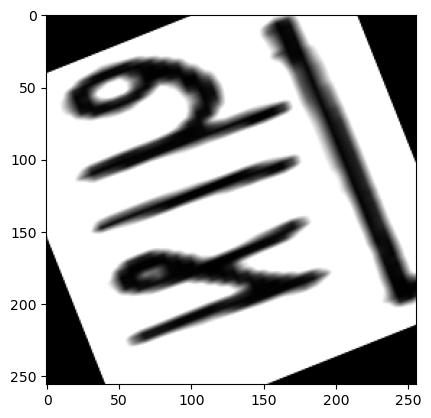

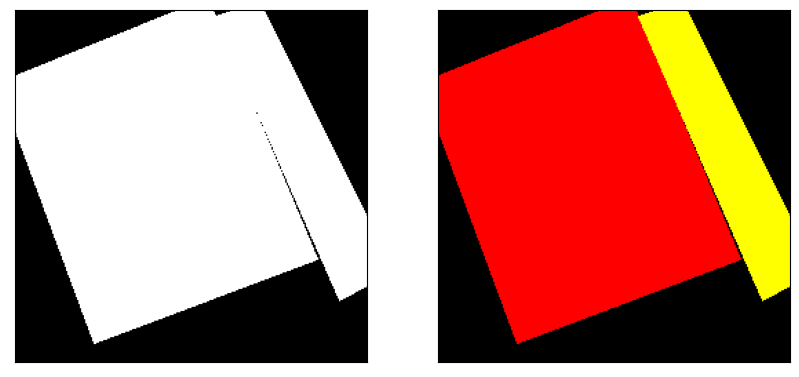

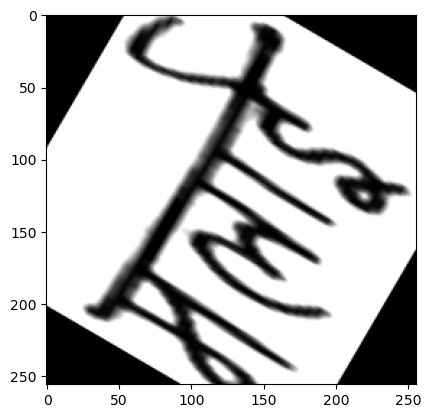

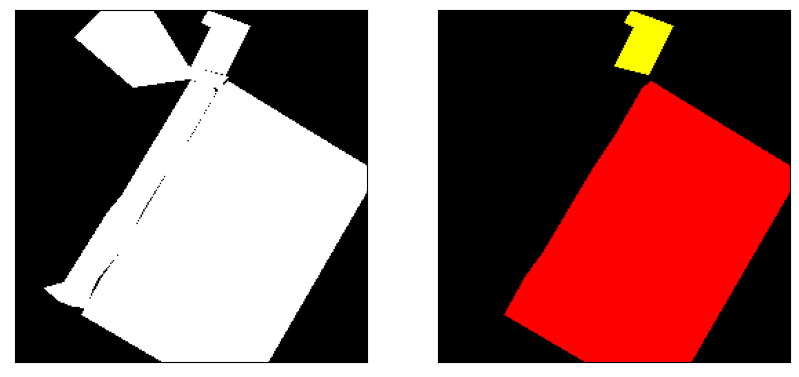

In [21]:
image_list = sorted(os.listdir('images'), key=lambda x: int(x.split('.')[0]))
annot_list = sorted(os.listdir('annotated'), key=lambda x: int(x.split('.')[0]))

for i, (im_fn, ann_fn) in enumerate(zip(image_list, annot_list)):
    
    seq_det = seq.to_deterministic()
    im_path = os.path.join('images', im_fn)
    ann_path = os.path.join('annotated', ann_fn)
    im_aug, aug_shape_dicts = augment_poly(im_path, ann_path)
    aug_mask = create_binary_masks(im_aug, aug_shape_dicts)
    
    im = cv2.imread(im_path, 1)
    im_color = draw_multi_masks(im, aug_shape_dicts)
    
    plt.imshow(im_aug)
    plt.show()
    plot_pair((aug_mask, im_color), gray=True)
    
    if i == 4:
        break